# Usage
1. `git clone git@github.com:lhycms/MaterSDK.git`
2. `cd matersdk`
3. `pip install .`
4. `pip install scipy`
5. `cd <your_path>/matersdk/demo/toolkit/pwmat`
6. 运行 `bondfft.ipynb` 脚本

In [1]:
import numpy as np
from typing import List
import matplotlib.pyplot as plt

from matersdk.toolkit.pwmat.avgbond import AvgBond, PairBond
from matersdk.io.pwmat.output.movement import Movement
from matersdk.data.deepmd.data_system import DpLabeledSystem

# Case 1. 计算体系中所有 `Li-Si` 键的长度

## Step 1. 自定义参数

In [2]:
# 1. Custom Parameter
movement_path = "/data/home/liuhanyu/hyliu/code/mlff/test/demo2/PWdata/data1/MOVEMENT"

element_1 = "Li"
element_2 = "Si"

cutoff = 3.2    # 最大键长

tot_running_time = 400   # 单位: fs

## Step 2. 查看 MOVEMENT 的信息

In [3]:
movement = Movement(movement_path=movement_path)
dsys = DpLabeledSystem.from_trajectory_s(movement, rcut=cutoff)
num_steps = len(dsys)   # 模拟步数
times_lst = np.linspace(0, tot_running_time, num_steps) # 时域的横坐标
print(dsys)

****************** LabeledSystem Summary *******************
	 * Images Number           : 550           
	 * Atoms Number            : 72            
	 * Virials Information     : True          
	 * Energy Deposition       : True          
	 * Elements List           :
		 - Li: 48              
		 - Si: 24              
************************************************************



## Step 2.1. 查看`cutoff`内，原子的最大近邻原子数

In [4]:
dsys.get_max_num_nbrs_real(rcut=cutoff)

13

## Step 3. 运行程序

In [5]:
### Step 3.1. 初始化 Bondfft 对象
avgbond = AvgBond(
                movement_path=movement_path,
                element_1=element_1,
                element_2=element_2,
                cutoff=cutoff)

In [6]:
### Step 3.2. 计算所有构型的 element_1 和 element_2 的平均键长
### Note: 当MOVEMENT结构较多时，这一步比较耗时！
frame_avg_bonds_array = avgbond.get_frames_avg_bond()

# 4. 绘制图像

## Step 4.1. 时域

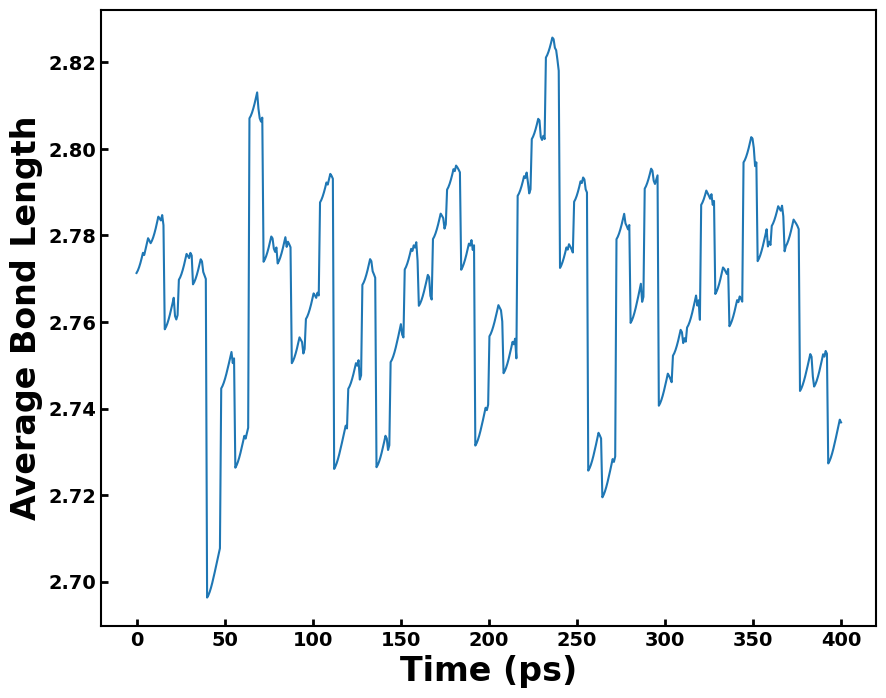

In [7]:
def plot_time(times_lst:List[float], frame_avg_bonds_lst:List[float]):
    plt.figure(figsize=(10, 8))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    # 1. xlabel / ylabel
    plt.xlabel("Time (ps)",
               fontsize=24,
               fontweight="bold")
    plt.ylabel("Average Bond Length",
               fontsize=24,
               fontweight="bold")
    # 2. xticks / yticks
    ax = plt.gca()
    plt.xticks(fontsize=14, 
        fontweight="bold"
        )
    plt.yticks(fontsize=14, 
        fontweight="bold"
        )
    # 3. 刻度线的粗细
    plt.tick_params(
        width=2,        # 刻度线的粗细
        length=5,       # 刻度线的长短
        #labelsize=28   # 刻度线的字体大小
        )
    # 4. 设置坐标轴的粗细
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(1.5);###设置底部坐标轴的粗细
    ax.spines['left'].set_linewidth(1.5);####设置左边坐标轴的粗细
    ax.spines['right'].set_linewidth(1.5);###设置右边坐标轴的粗细
    ax.spines['top'].set_linewidth(1.5);###设置右边坐标轴的粗细
    
    plt.plot(times_lst, frame_avg_bonds_lst)
    plt.show()


plot_time(times_lst, frame_avg_bonds_array)

## Step 4.2.频域 -- 利用 scipy 完成 FFT

In [9]:
from scipy.fft import fft

# 1. Perform the FFT using the fft function
fft_results = fft(frame_avg_bonds_array)
# 2. Calculate the magnitudes of the FFT coefficients:
magnitudes = np.abs(fft_results)
sampling_rate = 1 / ((times_lst[1] - times_lst[0]) * 10E-15)  # Assuming the data is sampled at 1 unit per sample
frequencies = np.fft.fftfreq(len(fft_results), d=1/sampling_rate)
frequencies_thz = frequencies / 10E12

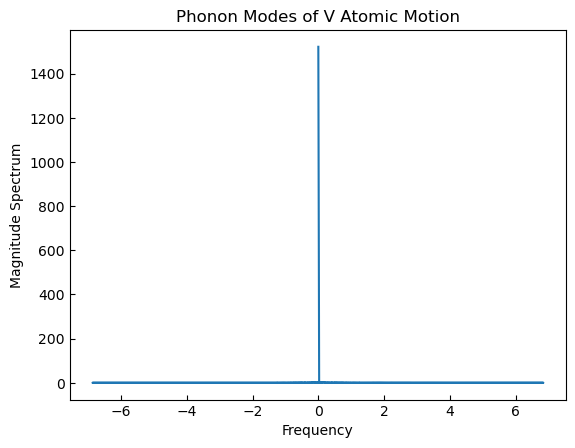

In [10]:
plt.plot(frequencies_thz, magnitudes)
plt.xlabel('Frequency')
plt.ylabel('Magnitude Spectrum')
plt.title('Phonon Modes of V Atomic Motion')
plt.show()

# Case 2. 指定`Li`和`Si`原子，然后计算其键长 (通过 index 指定原子)

## Step 1. 自定义参数

In [11]:
# 1. Custom Parameter
movement_path = "/data/home/liuhanyu/hyliu/code/mlff/test/demo2/PWdata/data1/MOVEMENT"

atom1_idx = 0   # 指定 Li 原子
atom2_idx = 49  # 指定 Si 原子

tot_running_time = 10   # 单位: ps

## Step 2. 运行程序

In [12]:
pairbond = PairBond(
                movement_path=movement_path,
                atom1_idx=atom1_idx,
                atom2_idx=atom2_idx)

### Step 2.1. 计算所有构型的 atom1_idx 和 atom2_idx 的键长
### Note: 当MOVEMENT结构较多时，这一步比较耗时！
frame_pair_bonds_array = pairbond.get_frames_pair_bond()

In [13]:
### Step 2.2. 获取时间坐标
steps_lst = [*(range(len(frame_avg_bonds_array)))]
times_lst = [tmp_step*tot_running_time/len(steps_lst) for tmp_step in steps_lst]
#frame_avg_bonds_lst

## Step 3. 绘制图像

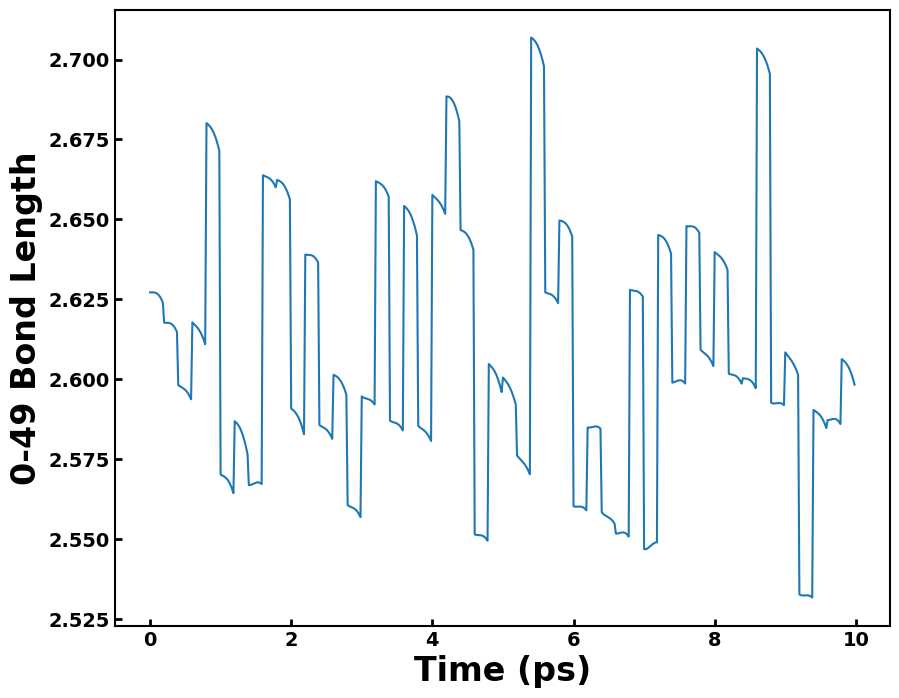

In [14]:
def plot_time(times_lst:List[float], frame_pair_bonds_lst:List[float]):
    plt.figure(figsize=(10, 8))
    plt.rcParams['xtick.direction'] = 'in'
    plt.rcParams['ytick.direction'] = 'in'

    # 1. xlabel / ylabel
    plt.xlabel("Time (ps)",
               fontsize=24,
               fontweight="bold")
    plt.ylabel(f"{atom1_idx}-{atom2_idx} Bond Length",
               fontsize=24,
               fontweight="bold")
    # 2. xticks / yticks
    ax = plt.gca()
    plt.xticks(fontsize=14, 
        fontweight="bold"
        )
    plt.yticks(fontsize=14, 
        fontweight="bold"
        )
    # 3. 刻度线的粗细
    plt.tick_params(
        width=2,        # 刻度线的粗细
        length=5,       # 刻度线的长短
        #labelsize=28   # 刻度线的字体大小
        )
    # 4. 设置坐标轴的粗细
    ax = plt.gca()
    ax.spines['bottom'].set_linewidth(1.5);###设置底部坐标轴的粗细
    ax.spines['left'].set_linewidth(1.5);####设置左边坐标轴的粗细
    ax.spines['right'].set_linewidth(1.5);###设置右边坐标轴的粗细
    ax.spines['top'].set_linewidth(1.5);###设置右边坐标轴的粗细
    
    plt.plot(times_lst, frame_pair_bonds_lst)
    plt.show()


plot_time(times_lst, frame_pair_bonds_array)